# Django 7일차

### 인증과 권한

HTTP의 특징?  
1. 비 연결 지향
2. 무상태  

서버-클라이언트간 '상태'를 유지하기 위한 기술?
1. 쿠키
2. 세션

로그인?
- 사용자에 대한 세션을 생성하는 것  

로그아웃?
- 세션을 클라이언트와 서버에서 삭제하는 것  

### Authentication with User

<b>개요</b>  

User Object와 User CRUD에 대한 이해  
- 회원 가입, 회원 탈퇴, 회원정보 수정, 비밀번호 변경  

### 회원 가입  

<b>개요</b>  

회원 가입은 User을 <mark>Create</mark>하는 것이며 <b>UserCreationForm</b> built-in-form을 사용  

&nbsp;

<b>UserCreationForm</b>  

주어진 username과 password로 권한이 없는 새 user를 생성하는 ModelForm  

3개의 필드를 가짐  

1. username (form the user model)
2. password1
3. password2

<a href="https://github.com/django/django/blob/stable/3.2.x/django/contrib/auth/forms.py#L75">https://github.com/django/django/blob/stable/3.2.x/django/contrib/auth/forms.py#L75</a>

<b>회원 가입 페이지 작성</b>  

```
### 회원 가입 페이지 작성
# accounts/urls.py 

from django.urls import path
from . import views

app_name = 'accounts'
urlpatterns = [
    ...
    path('signup/', views.signup, name='signup'),
    
]


# accounts/templates/accounts/singup.html

{% extends 'base.html' %}

{% block content %}
  <h1>회원가입</h1>

  <form action="{% url 'accounts:signup' %}" method="POST">
    {% csrf_token %}
    {{ form.as_p }}
    <input type="submit" value="회원가입">
  </form>
  <a href="{% url 'articles:index' %}">목록보기</a>
{% endblock content %}


# accounts/views.py

from django.contrib.auth.forms import UserCreationForm

...

def signup(request):
    if request.method == "POST":
        form = UserCreationForm(request.POST)
            pass
    else:
        form = UserCreationForm()
        context = {'form': form,}
        return render(request, 'accounts/signup.html', context)


### 회원가입 링크 작성 후 페이지 확인
# templates/base.html
# 아래 내용을 기존에 추가

<a href="{%  url 'accounts:signup' %}">Signup</a>


### 회원가입 로직 작성
def signup(request):
    if request.method == "POST":
        form = CustomUserCreationForm(request.POST)
        if form.is_valid():
            user = form.save()
            return redirect("articles:index")
    else:
        form = CustomUserCreationForm()
        context = {'form': form,}
        return render(request, 'accounts/signup.html', context)

```

<b>회원가입 진행 후 에러 페이지를 확인</b>  

회원 가입에 사용하는 UserCreationForm이 우리가 대체한 커스텀 유저 모델이 아닌 기존 유저 모델로 인해 작성 된 클래스이기 때문에  

<a href="https://github.com/django/django/blob/main/django/contrib/auth/forms.py#L106">https://github.com/django/django/blob/main/django/contrib/auth/forms.py#L106</a>  

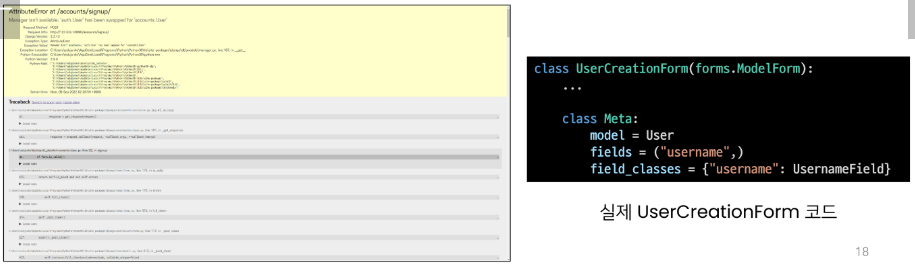

### Custom user & built-in auth forms

<b>개요</b>  

Custom user와 기존 Built-in auto forms 간의 관계  

Custom user로 인한 Built-in auth forms 변경  

&nbsp;

<b>AbstractBaseUser의 모든 subclass와 호환되는 forms</b>  

아래 Form 클래스는 User 모델을 대체하더라도 커스텀하지 않아도 사용가능  

1. AuthenticationForm
2. SetPasswordForm
3. PasswordChangeForm
4. AdminPassWordChangeForm

기존 User 모델을 참조하는 Form이 아니기 때문  



<b>커스텀 유저 모델을 사용하려면 다시 작성하거나 확장해야 하는 forms</b>  

1. UserCreationForm
2. UserChangeForm

두 form 모두 ```class Meta: model = User```가 등록된 form이기 때문에 반드시 커스텀(확장)해야 함  

& nbsp;

<b>UserCreationForm() 커스텀 하기</b>  

```
# accounts/forms.py

from django.contrib.auth import get_user_model
from django.contrib.auth.forms import UserCreationForm, UserChangeForm

class CustomUserCreationForm(UserCreationForm):
    class Meta(UserCreationForm.Meta):
        model = get_user_model()


class CustomUserChangeForm(UserChangeForm):
    class Meta(UserChangeForm.Meta):
        model = get_user_model()
```

&nbsp;

<b>get_user_model()</b>  

<mark>"현재 프로젝트에서 활성화된 사용자 모델(active user model)"</mark>을 반환  

직접 참조하지 않는 이유  

- 예를 들어 기존 User 모델이 아닌 User 모델을 커스텀한 상황에서는 커스텀 User 모델을 자동으로 반환해주기 때문

Django는 User 클래스를 직접 참조하는 대신 **get_user_model()**을 사용해 참조해야 한다고 강조하고 있음  

User model 참조에 대한 자세한 내용은 추후 모델 관계 수업에서 다룰 예정  


<b>CustomUserCreationForm()으로 대체</b>  

```
# accounts/views.py

from django.contrib.auth.forms import UserCreationForm, PasswordChangeForm
from .forms import CustomUserCreationForm, CustomUserChangeForm

def signup(request):
    if request.method == "POST":
        form = CustomUserCreationForm(request.POST)
        if form.is_valid():
            user = form.save()
            auth_login(request, user)
            return redirect("articles:index")
    else:
        form = CustomUserCreationForm()
        context = {'form': form,}
        return render(request, 'accounts/signup.html', context)
```

<b>회원가입 진행 후 테이블 확인</b>  

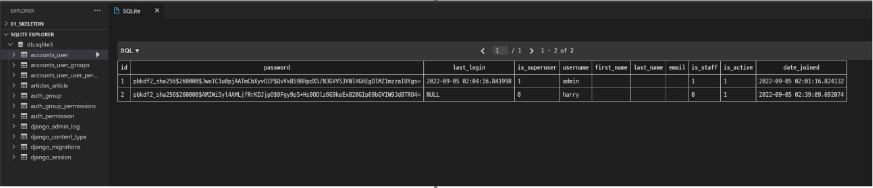

<b>회원가입 후 곧바로 로그인 진행</b>  

```
def signup(request):
    if request.method == "POST":
        form = CustomUserCreationForm(request.POST)
        if form.is_valid():
            user = form.save()
            auth_login(request, user) # 추가된 부분
            return redirect("articles:index")
    else:
        form = CustomUserCreationForm()
        context = {'form': form,}
        return render(request, 'accounts/signup.html', context)
```

<b>[참고] USERCreationForm의 save 메서드</b>  

user를 반환하는 것을 확인  
<a href="https://github.com/django/django/blob/main/django/contrib/auth/forms.py#L139">https://github.com/django/django/blob/main/django/contrib/auth/forms.py#L139</a>

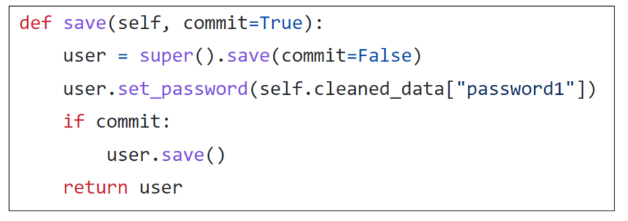

### 회원 탈퇴

<b>개요</b>  

회원 탈퇴하는 것은 DB에서 유저를 Delete하는 것과 같음  

```
# acccounts/urls.py

from django.urls import path
from . import views

app_name = 'accounts'
urlpatterns = [
    ...
    path('delete/', views.delete, name='delete'),
    
]


# accounts/views.py

def delete(request):
    request.user.delete()
    return redirect('articles:index')


# templates/base.html
# 아래 내용을 추가

<form action="{% url 'accounts:delete' %}" method="POST">
    {% csrf_token %}
    <input type="submit" value="회원탈퇴">
</form>

```

<b>[참고] 탈퇴하면서 해당 유저의 세션 정보도 함께 지우고 싶은 경우</b>  

탈퇴(1) 후 로그아웃(2)의 순서가 바뀌면 안됨  
- 먼저 로그아웃 해버리면 해당 요청 객체 정보가 없어지기 때문에, 탈퇴에 필요한 정보 또한 없어지기 때문에

```
def delete(request):
    request.user.delete()
    auth_logout(request)
    return redirect('articles:index')
```

### 회원정보 수정  

<b>개요</b>  

회원정보 수정은 User를 Update하는 것이며 <mark>UserChangeForm</mark> bulit-in form을 사용  

&nbsp;

<b>UserChangeForm</b>  

사용자의 정보 및 권한을 변경하기 위해 admin 인터페이스에서 사용되는 ModelForm  

UserChangeForm 또한 ModelForm이기 때문에 instance 인자로 기존 user 데이터 정보를 받는 구조 또한 동일함  

이미 이전에 CustomUserChangeForm으로 확장 했기 때문에 CustomUserChangeForm을 사용

&nbsp;

```
### 회원정보 수정 페이지 작성  
# accounts/urls.py

from django.urls import path
from . import views

app_name = 'accounts'
urlpatterns = [
    ...
    path('update/', views.update, name='update'),

]


# accounts/update.html

{% extends 'base.html' %}

{% block content %}
  <h1>회원정보 수정</h1>

  <form action="{% url 'accounts:update' %}" method="POST">
    {% csrf_token %}
    {{ form.as_p }}
    <input type="submit" value="수정하기">
  </form>
  <a href="{% url 'articles:index' %}">목록보기</a>
{% endblock content %}


# accounts/views.py

def update(request):
    if request.method == "POST":
        pass
    else:
        form = CustomUserChangeForm(instance=request.user)
        context = {'form': form,}
        return render(request, 'accounts/update.html', context)


###회원정보 수정 페이지 링크 작성  
# templates/base.html
# 밑을 추가

<a href="{% url 'accounts:update' %}">회원정보 수정</a>
```

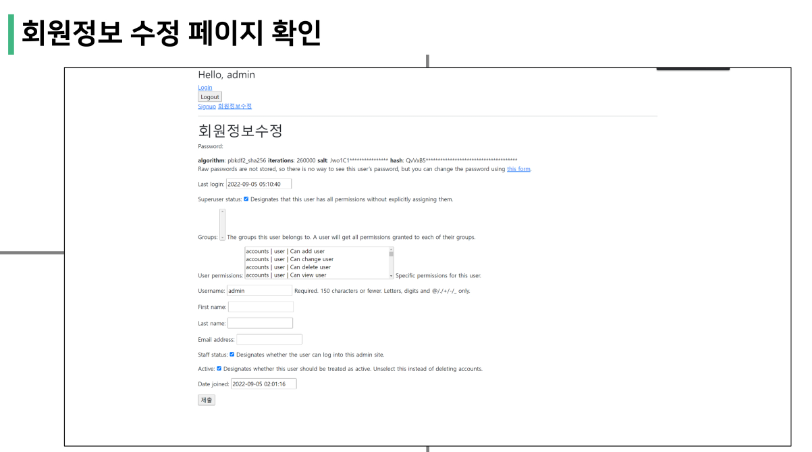

<b>UserChangeForm 사용 시 문제점</b>  

일반 사용자가 접근해서 안될 정보들(fields)까지 모두 수정이 가능해짐  
- admin 인터페이스에서 사용되는 ModelForm이기 때문  

따라서 UserChangeForm을 상속받아 작성해 두었던 서브클래스   
CustomUserChangeForm에서 접근 가능한 필드를 조정해야 함  

&nbsp;

<b>CustomUserChangeForm fields 재정의</b>  

User 모델의 fields명은 어떻게 알 수 있을까?  

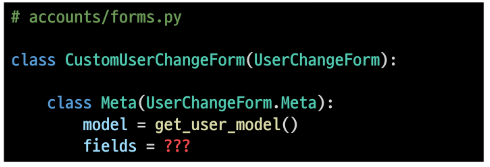

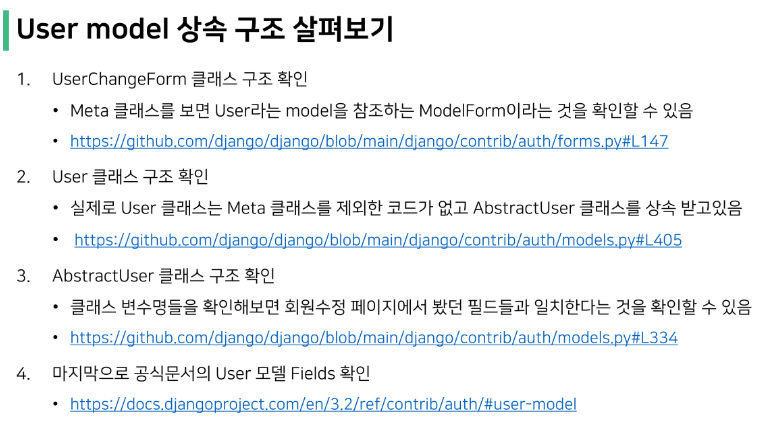

수정하고자 하는 필드 작성 후 출력 변화 확인  

```
# accounts/forms.py

class CustomUserChangeForm(UserChangeForm):
    class Meta(UserChangeForm.Meta):
        model = get_user_model()
        fields = ('username', 'email', 'first_name', 'last_name', )
```

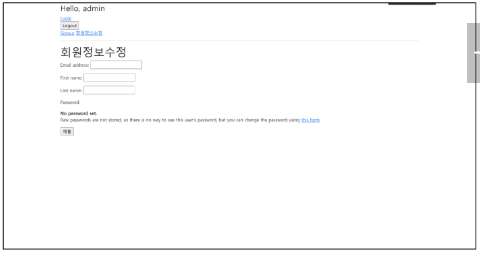

<b>회원정보 수정 로직</b>  

작성 후 실제 회원 정보가 수정 되었는지 확인  

```
# accounts.views/py

def update(request):
    if request.method == "POST":
        form = CustomUserChangeForm(request.POST, instance=request.user)
        # form = CustomUserChangeForm(data=request.POST, instance=request.user)
        if form.is_valid():
            form.save()
            return redirect('articles:index')
    else:
        form = CustomUserChangeForm(instance=request.user)
        context = {'form': form,}
        return render(request, 'accounts/update.html', context)

```

### 비밀번호 변경  

<b>PasswordChangeForm</b>  

사용자가 비밀번호를 변경할 수 있도록 하는 Form  

이전 비밀번호를 입력하여 비밀번호를 변경할 수 있도록 함  

이전 비밀번호를 입력하지 않고 비밀번호를 설정할 수 있는 SetPasswordForm을 상속받는 서브 클래스  

&nbsp;

회원정보 수정 페이지에서 비밀번호 변경 form 주소를 확인해보기  

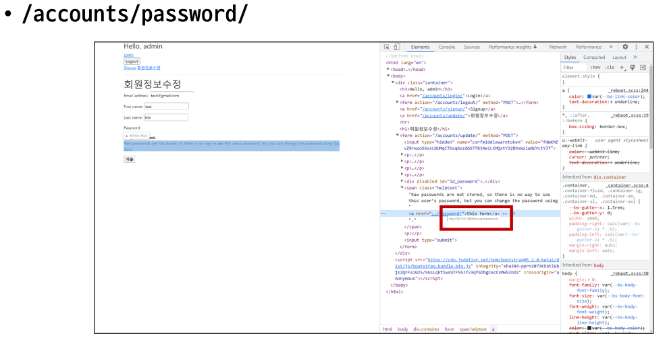

<b> 비밀번호 변경 페이지 작성</b>  

```
# accounts/urls.py
from django.urls import path
from . import views

app_name = 'accounts'
urlpatterns = [
    ...
    path('password/', views.change_password, name='change_password'),
    
]


# accounts/templates/accounts/change_pasword.html

{% extends 'base.html' %}

{% block content %}
  <h1>비밀번호 변경</h1>

  <form action="{% url 'accounts:change_password' %}" method="POST">
    {% csrf_token %}
    {{ form.as_p }}
    <input type="submit" value="수정하기">
  </form>
  <a href="{% url 'articles:index' %}">목록보기</a>
{% endblock content %}


# accounts/views.py

def change_password(request):
    if request.method == "POST":
        pass
    else:
        form = PasswordChangeForm(request.user)

    context = {'form': form,}
    return render(request, 'accounts/change_password.html', context)
```

<b>[참고] SetPasswordForm 살펴보기</b>  

PasswordChangeForm은 SetPasswordForm의 하위 클래스이기 때문에  
SetPasswordForm을 확인  

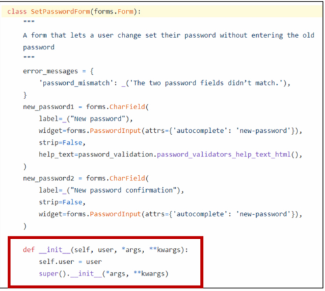

<b>비밀번호 변경 로직 작성</b>  

작성 후 비밀번호 변경 확인  
- 변경 후 로그인 상태가 지속되 못하는 문제 발생  

```
# accounts/views.py

def change_password(request):
    if request.method == "POST":
        form = PasswordChangeForm(request.user, request.POST)
        # form = PasswordChangeForm(user=request.user, data=request.POST)
        if form.is_valid():
            form.save()
            return redirect('articles:index')
    else:
        form = PasswordChangeForm(request.user)

    context = {'form': form,}
    return render(request, 'accounts/change_password.html', context)
```

<b>암호 변경 시 세션 무효화 방지하기</b>  

비밀번호가 변경되면 기존 세션과의 회원 인증 정보가 일치하지 않게 되어 로그인 상태가 유지되지 못함  

비밀번호는 잘 변경 되었으나 비밀번호가 변경되면서 기존 세션과의 회원 인증 정보가 일치하지 않기 때문에  

&nbsp;

<b>update_session_auth_hash()</b>

```update_session_auth_hash(request, user)```  

현재 요청(current request)과 새 session data가 파생될 업데이트 된 사용자 객체를 가져오고, session data를 적절하게 업데이트 해줌  

암호가 변경되어도 로그아웃 되지 않도록 새로운 password의 session data로 sessionㅇ르 업데이트   

```
# accounts/views.py

from django.contrib.auth import update_session_auth_hash

...
def change_password(request):
    if request.method == "POST":
        form = PasswordChangeForm(request.user, request.POST)
        # form = PasswordChangeForm(user=request.user, data=request.POST)
        if form.is_valid():
            form.save()
            update_session_auth_hash(request, form.user)
            return redirect('articles:index')
    else:
        form = PasswordChangeForm(request.user)

    context = {'form': form,}
    return render(request, 'accounts/change_password.html', context)
```

### View decorators

<b>개요</b>  

View decorators를 사용해 view 함수를 단단하게 만들기  

&nbsp;

<b>데코레이터 (Decorator)</b>

기존에 작성된 함수에 기능을 추가하고 싶을 때, 해당 함수를 수정하지 않고 기능을 추가해주는 함수  

Django는 다양한 HTTP 기능을 지원하기 위해 view 함수에 적용할 수 있는 여러 데코레이터를 제공  

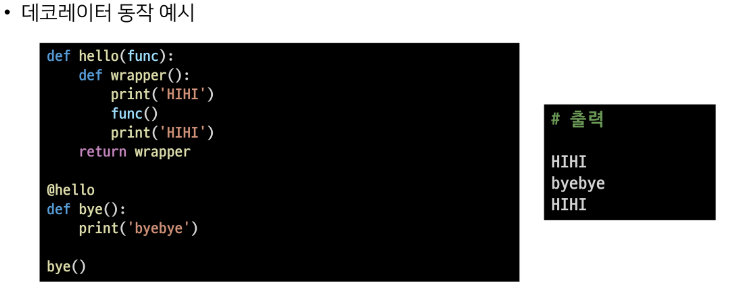

### Allowed HTTP methods

<b>개요</b>  

django.views.decorators.http의 데코레이터를 사용하여  
요청 메서드를 기반으로 접근을 제한할 수 있음  

일치하지 않는 메서드 요청이라면 405 Method Not Allowed를 반환  

메서드 목록

1. require_http_methods()
2. require_POST()
3. require_safe()

200: OK  
400: 클라언트 잘못  
500: 서버 잘못  

<b>[참고] 405 Method Not Allowed</b>  

요청 방법이 서버에게 전달되었으나 사용 불가능한 상태  

&nbsp;

<b>require_http_methods()</b>  

View 함수가 특정한 요청 method만 허용하도록 하는 데코레이터  

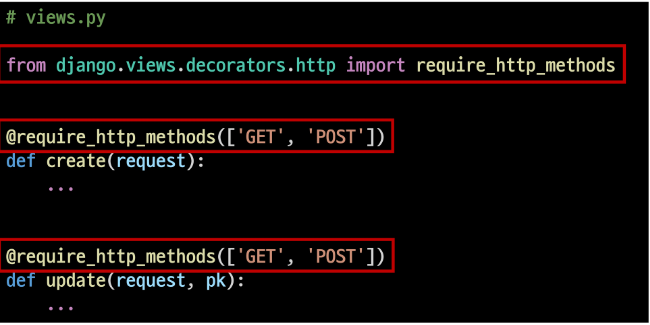

<b>require_POST()</b>  

View 함수가 POST 요청 method만 허용하도록 하는 데코레이터  

```
# accounts/views.py

from django.views.decorators.http import require_http_methods, require_POST

@require_http_methods(['POST'])
def delete(request):
    request.user.delete()
    auth_logout(request)
    return redirect('articles:index')
```

&nbsp;

<b>require_POST()</b>  

url로 delete 시도 후 서버 로그에서 405 http status code 확인 해보기  

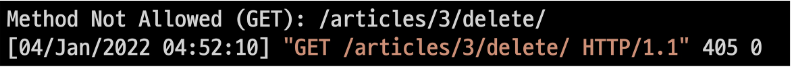

<b>require_safe()</b>  

require_GET이 있지만 Django에서는 require_safe를 사용하는 것을 권장함  

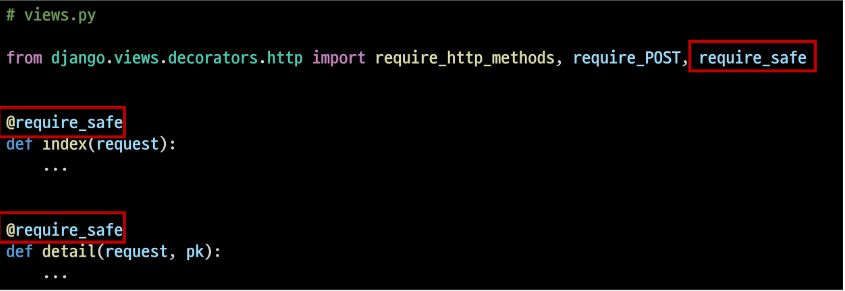

### Limiting access to logged-in users

<b>개요</b>  

로그인 사용자에 대한 접근 제한하기  
**is_authenticated** attribute  

&nbsp;

<b>is_authenticated</b>  

User model의 속성(attributes) 중 하나  

사용자가 인증되었는지 여부를 알 수 있는 방법  

모든 User 인스턴스에 대해 항상 True인 읽기 전용 속성  
- AnonymousUser에 대해서는 항상 False

일반적으로 **request.user**에서 이 속성 사용 (request.user.is.authenticated)  

<font color="red">권한(permission)과는 관련이 없으며, 사용자가 활성화 상태(active)이거나 <br> 유효한 세션 (valid session)을 가지고 있는지도 확인하지 않음</font>

<b>is_authenticated 적용하기</b>  

로그인과 비로로그인 상태에서 출력되는 링크를 다르게 설정하기  

```
# templates/base.html

{% if user.is_authenticated %}
<a href="{% url 'accounts:logout' %}">로그아웃</a>
<a href="{% url 'accounts:update' %}">회원정보 수정</a>
<form action="{% url 'accounts:delete' %}" method="POST">
    {% csrf_token %}
    <input type="submit" value="회원탈퇴">
</form>
<h3 id="user-hello"><i>안녕하세요, {{user}} 님 !</i></h3>
{% else %}
<a href="{% url 'accounts:signup' %}">회원가입</a>
<a href="{% url 'accounts:login' %}">로그인</a>
{% endif %}
```

인증된 사용자만 게시글 작성 링크를 볼 수 있또록 처리하기  

하지만 아직 비로그인 상태로도 URL을 직접 입력하면 게시글 작성 페이지로 갈 수 있음  

&nbsp;

인증된 사용자라면 로그인 로직을 수행할 수 없도록 처리  

```
# accounts/templates/accounts/views.py

def login(request):
    if request.user.is_authenticated:
        return redirect('articles:index')
    ...

```